<a href="https://colab.research.google.com/github/yuvrajiro/MA691_Rahul_Goswami/blob/main/Assignment/Assignment01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment

**Name : Rahul Goswami  
Course : MA691 Advanced Statistical Algorithm  
Roll No. : 206123106**



---

### *Data*

Data is taken for this project from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php) titled [BitcoinHeistRansomwareAddressDataset Data Set](https://archive.ics.uci.edu/ml/datasets/BitcoinHeistRansomwareAddressDataset)  

**Attribute Information:**

Features  
address: String. Bitcoin address.  
year: Integer. Year.  
day: Integer. Day of the year. 1 is the first day, 365 is the last day.  
length: Integer.  
weight: Float.  
count: Integer.  
looped: Integer.  
neighbors: Integer.  
income: Integer. Satoshi amount (1 bitcoin = 100 million satoshis).  
label: Category String. Name of the ransomware family (e.g., Cryptxxx, cryptolocker etc) or white (i.e., not known to be ransomware).  



## Aim

Our Aim here is to classify data in Non-Ransomware that is labeled by *white* and Ransomware , we are going to assume ransomware as positive and non ransomware is negative 



### Importing Packages

In [ ]:
import pandas
import tensorflow
import seaborn
import numpy
import sklearn
import os
import tempfile
import matplotlib

### Importing Data

In [ ]:
data = pandas.read_csv("BitcoinHeistData.csv")

### Exploration


In [ ]:
data.shape

(2916697, 10)

In [ ]:
data.describe()

,year,day,length,weight,count,looped,neighbors,income
count,2.916697e+06,2.916697e+06,2.916697e+06,2.916697e+06,2.916697e+06,2.916697e+06,2.916697e+06,2.916697e+06
mean,2.014475e+03,1.814572e+02,4.500859e+01,5.455192e-01,7.216446e+02,2.385067e+02,2.206516e+00,4.464889e+09
std,2.257398e+00,1.040118e+02,5.898236e+01,3.674255e+00,1.689676e+03,9.663217e+02,1.791877e+01,1.626860e+11
min,2.011000e+03,1.000000e+00,0.000000e+00,3.606469e-94,1.000000e+00,0.000000e+00,1.000000e+00,3.000000e+07
25%,2.013000e+03,9.200000e+01,2.000000e+00,2.148438e-02,1.000000e+00,0.000000e+00,1.000000e+00,7.428559e+07
50%,2.014000e+03,1.810000e+02,8.000000e+00,2.500000e-01,1.000000e+00,0.000000e+00,2.000000e+00,1.999985e+08
75%,2.016000e+03,2.710000e+02,1.080000e+02,8.819482e-01,5.600000e+01,0.000000e+00,2.000000e+00,9.940000e+08
max,2.018000e+03,3.650000e+02,1.440000e+02,1.943749e+03,1.449700e+04,1.449600e+04,1.292000e+04,4.996440e+13


In [ ]:
data.dtypes

address       object
year           int64
day            int64
length         int64
weight       float64
count          int64
looped         int64
neighbors      int64
income       float64
label         object
dtype: object

In [ ]:
data.nunique(axis=0)

address      2631095
year               8
day              365
length            73
weight        785669
count          11572
looped         10168
neighbors        814
income       1866365
label             29
dtype: int64

We Can See There are 29 , Here we have to do super labelling in Ransomware and non- Ransomware

In [ ]:
data["label"] = data["label"] != "white"                  # Changes label to True or 1 if the labelled as Ransomware

### Visualization and Analysis

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


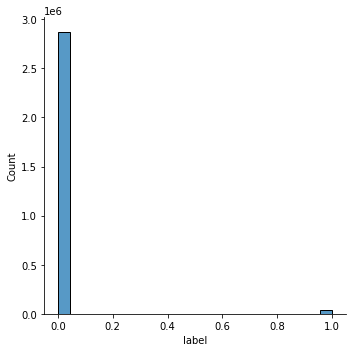

In [ ]:
seaborn.displot(data, x="label")


We Can Clearly See We have a Imbalanced Data There are more non Ransomware than Ransomware thats why we have to intialize or mode so that it converges fast , One of the idea for initalization is to only initialize the output bias by log of positive/negative 

$$ output \ bias = log(\frac{pos}{negative}) $$

In [ ]:
pos = sum(data["label"])
neg = sum(data["label"]==0)
print(pos , neg)

41413 2875284


**Let us take a look Densities of the Features of our Data**

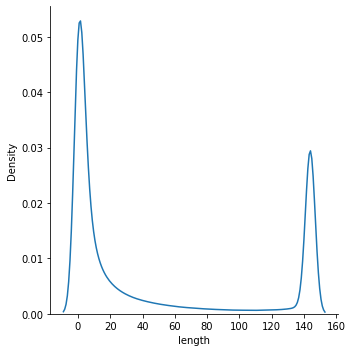

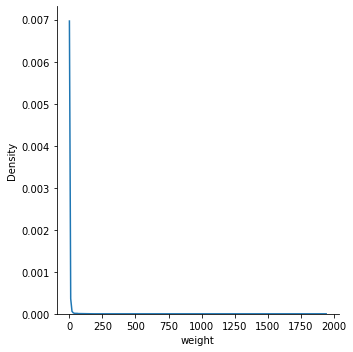

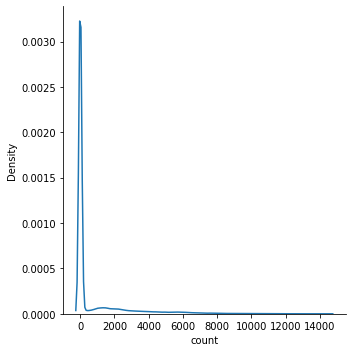

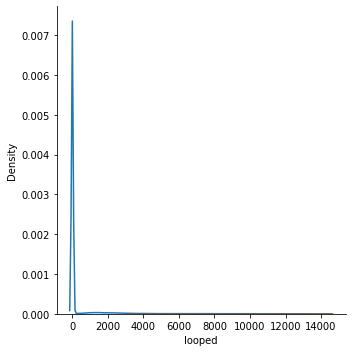

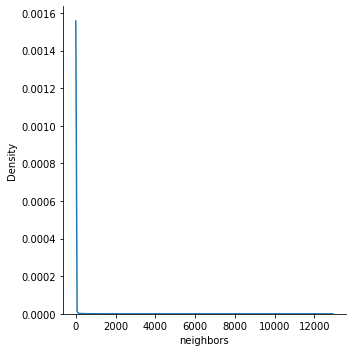

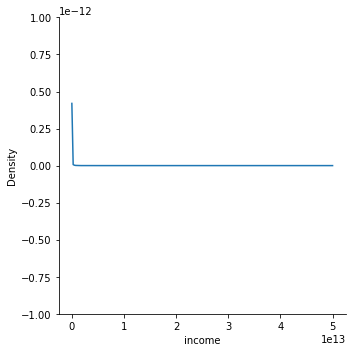

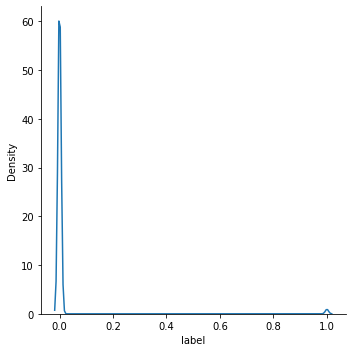

In [ ]:
for feature in list(data.columns)[1:10]:
  seaborn.displot(data, x=feature, kind="kde")


**Since Most of our features are Right Skewed so let us Take Log For those values so that our dataset tends to normalization**

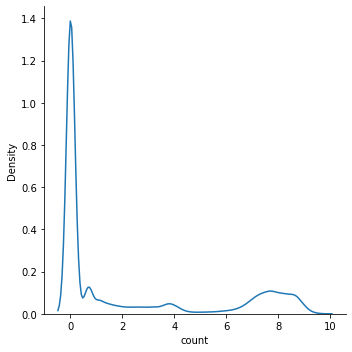

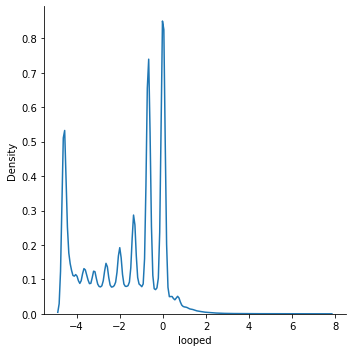

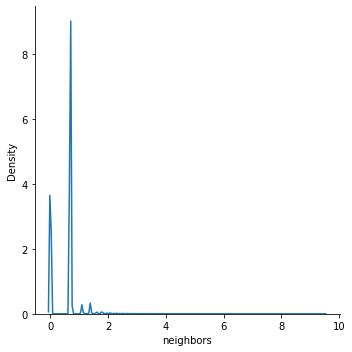

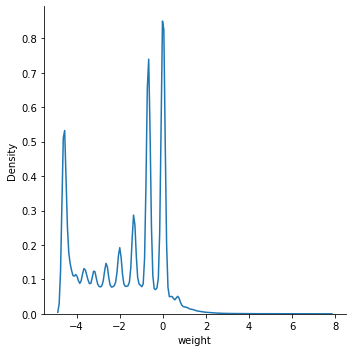

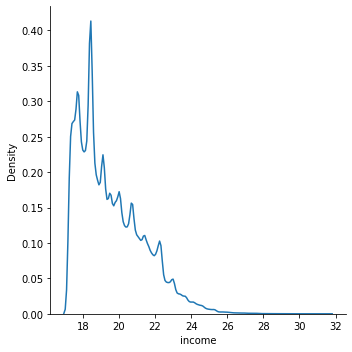

In [ ]:
data["count"] = numpy.log(data["count"]+0.01)
data["looped"] = numpy.log(data["weight"]+0.01)
data["neighbors"] = numpy.log(data["neighbors"]+0.01)
data["weight"] = numpy.log(data["weight"]+0.01)
data["income"] = numpy.log(data["income"]+0.01)

seaborn.displot(data, x="count", kind="kde")
seaborn.displot(data, x="looped", kind="kde")
seaborn.displot(data, x="neighbors", kind="kde")
seaborn.displot(data, x="weight", kind="kde")
seaborn.displot(data, x="income", kind="kde")

*Since We Can see there is an uniformity in case of Year  plus we personally belief that the Address and yeardoesnot contribute to the learning whether a heist is a ransomware or not*

**Why Not Remove Days ?**

We can see from the densities of days that on the last days of the year attacks are less probable than other days so I think it contributes to the Learning 



In [ ]:
data.pop("year")
data.pop("address")

## Preparing Dataset

Using Sklearn Module for train test split , randomly taking 80% train and 20% as test data , and taking 20% of the train data as a validation set , however we can do here Cross Validation but that would not be necessary since data is big 

In [ ]:
train_set, test_set = sklearn.model_selection.train_test_split(data, test_size=0.2)
train_set, val_set = sklearn.model_selection.train_test_split(train_set, test_size=0.2)

Converting DataFrames into Numpy array for easy operations


In [ ]:
train_labels = numpy.array(train_set.pop('label'))
val_labels = numpy.array(val_set.pop('label'))
test_labels = numpy.array(test_set.pop('label'))

train_features = numpy.array(train_set)
val_features = numpy.array(val_set)
test_features = numpy.array(test_set)

### Scaling and Centering

In [ ]:
scaler = sklearn.preprocessing.StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = numpy.clip(train_features, -5, 5)
val_features = numpy.clip(val_features, -5, 5)
test_features = numpy.clip(test_features, -5, 5)



## Tensorflow

Here we are going to make a Tensorflow Model with 2 Hidden Layer and one Droput layer with p = 0.5 , we also gonna use metrics from the keras to evaluate the model while training, we are going to provide initial bias option as an argument to `make_model` function  

In [ ]:
METRICS = [
      tensorflow.keras.metrics.TruePositives(name='tp'),
      tensorflow.keras.metrics.FalsePositives(name='fp'),
      tensorflow.keras.metrics.TrueNegatives(name='tn'),
      tensorflow.keras.metrics.FalseNegatives(name='fn'), 
      tensorflow.keras.metrics.BinaryAccuracy(name='accuracy'),
      tensorflow.keras.metrics.Precision(name='precision'),
      tensorflow.keras.metrics.Recall(name='recall'),
      tensorflow.keras.metrics.AUC(name='auc'),
]

def make_model(metrics=METRICS, output_bias=None, learning_rate = 1e-3):
  if output_bias is not None:
    output_bias = tensorflow.keras.initializers.Constant(output_bias)                                   # Initialize the Output bias randomly if not given
  model = tensorflow.keras.Sequential([
      tensorflow.keras.layers.Dense(16, activation='relu',input_shape=(train_features.shape[-1],)),     # First Layer with 16 Nodes and Sigmoid as an activation Function
      tensorflow.keras.layers.Dropout(0.5),                                                             # Droput that will Drop Randomly 50% of the nodes Basically used for Regilarization 
      tensorflow.keras.layers.Dense(1, activation='sigmoid',bias_initializer=output_bias),              # Output Layer
  ])

  model.compile(
      optimizer=tensorflow.keras.optimizers.Adam(lr= learning_rate),                                              # Using Adam as an Optimizer and learning rate 0.001
      loss=tensorflow.keras.losses.BinaryCrossentropy(),                                                # Cross Entropy Loss
      metrics=metrics)

  return model

Here We are going to use 100 Epochs and Batch Size of 22000 Since we want every batch have decent numbers of Ransomware Labels that is 1, and we are also using early stopping criteria

In [ ]:
EPOCHS = 100                              # Setting The number of Epochs
BATCH_SIZE = 22000                        # Setting Batch Size

early_stopping = tensorflow.keras.callbacks.EarlyStopping(
    monitor='precision', 
    verbose=1,
    patience=10,                          # Stop when Precison doesnot change fo upto 10 Epochs
    mode='max',
    restore_best_weights=True)            # To fetch Best Weights From the Epochs

In [ ]:
model = make_model()
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 16)                128       
_________________________________________________________________
dropout_17 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 17        
Total params: 145
Trainable params: 145
Non-trainable params: 0
_________________________________________________________________


Calculating The  Initial Bias

In [ ]:
initial_bias = numpy.log([pos/neg])
initial_bias

array([-4.24031189])

Storing Initial Weights  so that when we run more models we can compare them there is not any bias in comparing due to the initalizations of the weights

In [ ]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [ ]:
model = make_model(output_bias =  initial_bias)
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/100
85/85 [==============================] - 8s 76ms/step - loss: 0.3060 - tp: 56.6744 - fp: 6811.9186 - tn: 936352.0233 - fn: 13446.4767 - accuracy: 0.9758 - precision: 0.0083 - recall: 0.0061 - auc: 0.4916 - val_loss: 0.1931 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 460006.0000 - val_fn: 6666.0000 - val_accuracy: 0.9857 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5136
Epoch 2/100
85/85 [==============================] - 6s 65ms/step - loss: 0.1923 - tp: 0.6977 - fp: 191.1744 - tn: 942926.4186 - fn: 13548.8023 - accuracy: 0.9856 - precision: 0.0030 - recall: 4.4052e-05 - auc: 0.4919 - val_loss: 0.1351 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 460006.0000 - val_fn: 6666.0000 - val_accuracy: 0.9857 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5127
Epoch 3/100
85/85 [==============================] - 6s 66ms/step - loss: 0.1454 - tp: 0.0000e+00 - fp: 60.6047 - tn: 943097.2442 - fn: 13509.2442 - accuracy: 0.9857 - prec

In [ ]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

In [ ]:
def plot_cm(labels, predictions, p=0.5):
  cm = sklearn.metrics.confusion_matrix(labels, predictions > p)
  matplotlib.pyplot.figure(figsize=(5,5))
  seaborn.heatmap(cm, annot=True, fmt="d")
  matplotlib.pyplot.title('Confusion matrix @{:.2f}'.format(p))
  matplotlib.pyplot.ylabel('Actual label')
  matplotlib.pyplot.xlabel('Predicted label')


loss :  0.1935615837574005
tp :  0.0
fp :  0.0
tn :  574886.0
fn :  8454.0
accuracy :  0.985507607460022
precision :  0.0
recall :  0.0
auc :  0.5043352246284485



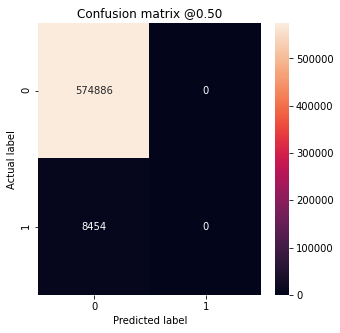

In [ ]:
baseline_results = model.evaluate(test_features, test_labels,batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

This result is not satisfactory since it classify each data as negative that is why we have 0 true positive and 0 False Positive , we have to implement **Class Weights**

### Class Weights

In This Method We Pass Weights to the observations which are minority class with heavy weights whereas the data observations which are in majority class with less weights, we can pass these weight to neural network with keras

In [ ]:
total = pos + neg
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.51
Weight for class 1: 35.21


In [ ]:
classweight_model = make_model(output_bias = initial_bias)
classweight_model.load_weights(initial_weights)

weighted_history = classweight_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    class_weight=class_weight) 

Epoch 1/100
85/85 [==============================] - 8s 76ms/step - loss: 0.7377 - tp: 4856.4651 - fp: 316175.1163 - tn: 626964.4186 - fn: 8671.0930 - accuracy: 0.6916 - precision: 0.0143 - recall: 0.3177 - auc: 0.5135 - val_loss: 0.6346 - val_tp: 2046.0000 - val_fp: 98778.0000 - val_tn: 361228.0000 - val_fn: 4620.0000 - val_accuracy: 0.7784 - val_precision: 0.0203 - val_recall: 0.3069 - val_auc: 0.5959
Epoch 2/100
85/85 [==============================] - 6s 67ms/step - loss: 0.6844 - tp: 6147.5349 - fp: 349768.6279 - tn: 593404.5116 - fn: 7346.4186 - accuracy: 0.6348 - precision: 0.0172 - recall: 0.4436 - auc: 0.5661 - val_loss: 0.6571 - val_tp: 4198.0000 - val_fp: 204528.0000 - val_tn: 255478.0000 - val_fn: 2468.0000 - val_accuracy: 0.5564 - val_precision: 0.0201 - val_recall: 0.6298 - val_auc: 0.6327
Epoch 3/100
85/85 [==============================] - 6s 67ms/step - loss: 0.6785 - tp: 7222.2093 - fp: 395237.0000 - tn: 547915.6512 - fn: 6292.2326 - accuracy: 0.5797 - precision: 0.01

In [ ]:
train_predictions_weighted = classweight_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = classweight_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.6389028429985046
tp :  6442.0
fp :  275818.0
tn :  299068.0
fn :  2012.0
accuracy :  0.5237254500389099
precision :  0.022822929546236992
recall :  0.7620061635971069
auc :  0.6898534297943115



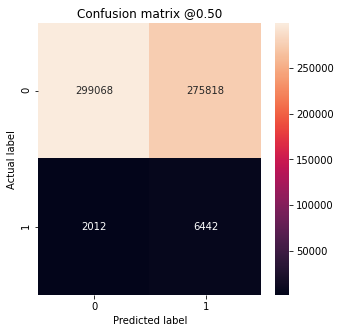

In [ ]:
weighted_results = classweight_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(classweight_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

**Hence This Result is better than earlier but it is too not aceptable since we have a a lot of false postive values**

### Conclusion
*   Imbalanced Dataset accuracy in not acceptable measures because it gives too much optimistic result 
*    Class Weights Method is better but not best for this data  
*    We Should try to clear the bias towards majority by oversampling from the Minority Class   



